## M1: Trend Prediction - Multiclass Classification (High/Medium/Low)
This notebook performs data fusion between weekly Google Trends and aggregated weekly weather data. 
It then trains a multiclass model to classify fashion category search interest as high, medium, or low.

In [78]:
%pip install lightgbm
# Imports and Data Loading
import pandas as pd
import numpy as np
import torch
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Load weekly Google Trends and weather data
trends = pd.read_parquet('./data/processed/weekly_trends.parquet')
weather = pd.read_parquet('./data/processed/weekly_weather_agg.parquet')

Note: you may need to restart the kernel to use updated packages.


### Data Fusion

Join Google Trends and aggregated weather data using the 'Date' field, ensuring both datasets are aligned weekly.

In [79]:
# Merge trends and weather data on the 'date' field
df = trends.merge(weather, on='date', how='left')

# Keep only one 'year' and one 'week' column
df['year'] = df['year_x']
df['week'] = df['week_x']
df = df.drop(columns=['year_x', 'week_x', 'year_y', 'week_y'])

# Drop rows with any missing data
df = df.dropna()

# Drop 'date' column
df = df.drop(columns=['date'])

# Reorder columns: year, week, date, then all others
first_cols = ['year', 'week', 'locality']
other_cols = [col for col in df.columns if col not in first_cols]
df = df[first_cols + other_cols]

df = df.drop(columns=['avg pressure mb', 'rain mm'])

# Check result
df


,year,week,locality,category,trend,avg temp °C,min temp °C,max temp °C,dew point °C,humidity %,visibility km,avg wind km/h,max wind km/h,gust km/h,slm pressure mb
1152,2015,53,10.0,acrylic,66.0,9.000000,4.000000,13.333333,5.666667,74.666667,9.666667,10.666667,17.333333,17.333333,1017.666667
1154,2015,53,20.0,acrylic,66.0,0.333333,-4.666667,5.666667,0.666667,84.666667,5.333333,4.000000,7.333333,0.000000,1017.000000
1155,2015,53,21.0,acrylic,66.0,0.333333,-4.666667,5.666667,0.666667,84.666667,5.333333,4.000000,7.333333,0.000000,1017.000000
1156,2015,53,22.0,acrylic,66.0,0.333333,-4.666667,5.666667,0.666667,84.666667,5.333333,4.000000,7.333333,0.000000,1017.000000
1158,2015,53,24.0,acrylic,66.0,1.333333,-0.666667,3.666667,1.333333,97.666667,2.000000,7.666667,16.000000,0.000000,1018.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1218715,2019,51,223.0,yellow,87.0,10.857143,8.142857,13.000000,9.428571,91.285714,11.142857,11.000000,20.285714,0.000000,1010.714286
1218716,2019,51,229.0,yellow,87.0,9.428571,5.714286,12.714286,8.142857,90.142857,12.428571,9.571429,20.142857,0.000000,1010.428571
1218717,2019,51,238.0,yellow,87.0,12.428571,10.000000,14.285714,9.571429,81.857143,15.000000,20.857143,29.714286,0.000000,1011.857143
1218718,2019,51,241.0,yellow,87.0,8.857143,7.142857,10.714286,8.714286,99.142857,6.142857,8.285714,17.428571,0.000000,1010.285714


### Category Encoding

Map each category string to a numeric category_id for machine learning compatibility.

In [80]:
# Create consistent category mapping
categories = sorted(df['category'].dropna().str.lower().str.strip().unique())
category2id = {cat: i for i, cat in enumerate(categories)}
category2id['unknown'] = -1

# Normalize category text and map
df['category_norm'] = df['category'].str.lower().str.strip()
df['category_id'] = df['category_norm'].map(category2id).fillna(-1).astype(int)

# Save the category encoding mapping into a file
torch.save(category2id, './data/processed/category2id.pt')

df

,year,week,locality,category,trend,avg temp °C,min temp °C,max temp °C,dew point °C,humidity %,visibility km,avg wind km/h,max wind km/h,gust km/h,slm pressure mb,category_norm,category_id
1152,2015,53,10.0,acrylic,66.0,9.000000,4.000000,13.333333,5.666667,74.666667,9.666667,10.666667,17.333333,17.333333,1017.666667,acrylic,0
1154,2015,53,20.0,acrylic,66.0,0.333333,-4.666667,5.666667,0.666667,84.666667,5.333333,4.000000,7.333333,0.000000,1017.000000,acrylic,0
1155,2015,53,21.0,acrylic,66.0,0.333333,-4.666667,5.666667,0.666667,84.666667,5.333333,4.000000,7.333333,0.000000,1017.000000,acrylic,0
1156,2015,53,22.0,acrylic,66.0,0.333333,-4.666667,5.666667,0.666667,84.666667,5.333333,4.000000,7.333333,0.000000,1017.000000,acrylic,0
1158,2015,53,24.0,acrylic,66.0,1.333333,-0.666667,3.666667,1.333333,97.666667,2.000000,7.666667,16.000000,0.000000,1018.333333,acrylic,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1218715,2019,51,223.0,yellow,87.0,10.857143,8.142857,13.000000,9.428571,91.285714,11.142857,11.000000,20.285714,0.000000,1010.714286,yellow,95
1218716,2019,51,229.0,yellow,87.0,9.428571,5.714286,12.714286,8.142857,90.142857,12.428571,9.571429,20.142857,0.000000,1010.428571,yellow,95
1218717,2019,51,238.0,yellow,87.0,12.428571,10.000000,14.285714,9.571429,81.857143,15.000000,20.857143,29.714286,0.000000,1011.857143,yellow,95
1218718,2019,51,241.0,yellow,87.0,8.857143,7.142857,10.714286,8.714286,99.142857,6.142857,8.285714,17.428571,0.000000,1010.285714,yellow,95


### Target Engineering

Assign three classes: 
- 2 = high (trend > 75th percentile)
- 1 = medium (trend between 50th and 75th percentile)
- 0 = low  (trend ≤ 50th percentile)

In [81]:
# Define percentiles
q50 = df['trend'].quantile(0.50)
q75 = df['trend'].quantile(0.75)

def trend_class(trend):
    if trend > q75:
        return 2 # high
    elif trend > q50:
        return 1 # medium
    else:
        return 0 # low

df['trend_class'] = df['trend'].apply(trend_class)
print(df['trend_class'].value_counts())

trend_class
0    604126
1    313099
2    289783
Name: count, dtype: int64


In [82]:
exclude = ['year', 'week', 'category', 'date', 'trend', 'trend_class', 'category_norm']  # aggiungi qui tutto ciò che vuoi escludere
feature_cols = [col for col in df.columns if col not in exclude]
X = df[feature_cols]
# Calcola i quantili "per category_id"
def assign_trend_class(row, qtable):
    q50 = qtable.loc[row['category_id'], 0.5]
    q75 = qtable.loc[row['category_id'], 0.75]
    if row['trend'] > q75:
        return 2  # high
    elif row['trend'] > q50:
        return 1  # medium
    else:
        return 0  # low

# Crea la tabella dei quantili per ogni categoria
qtable = df.groupby('category_id')['trend'].quantile([0.5, 0.75]).unstack(level=-1)

# Applica la funzione riga per riga (usa qtable di sopra)
df['trend_class_category'] = df.apply(lambda row: assign_trend_class(row, qtable), axis=1)

# Controlla la nuova distribuzione (più bilanciata)
dist_cat = df.groupby('category_id')['trend_class_category'].value_counts(normalize=True).unstack(fill_value=0)
print(dist_cat)

# Puoi usarla ora come nuovo target:
y = df['trend_class_category']

trend_class_category         0         1         2
category_id                                       
0                     0.533365  0.216655  0.249980
1                     0.510061  0.274636  0.215303
2                     0.500358  0.259922  0.239720
3                     0.557146  0.270023  0.172831
4                     0.543307  0.226358  0.230335
...                        ...       ...       ...
91                    0.523741  0.264058  0.212201
92                    0.750020  0.000000  0.249980
93                    0.538296  0.244969  0.216734
94                    0.505130  0.317665  0.177205
95                    0.529627  0.225324  0.245049

[96 rows x 3 columns]


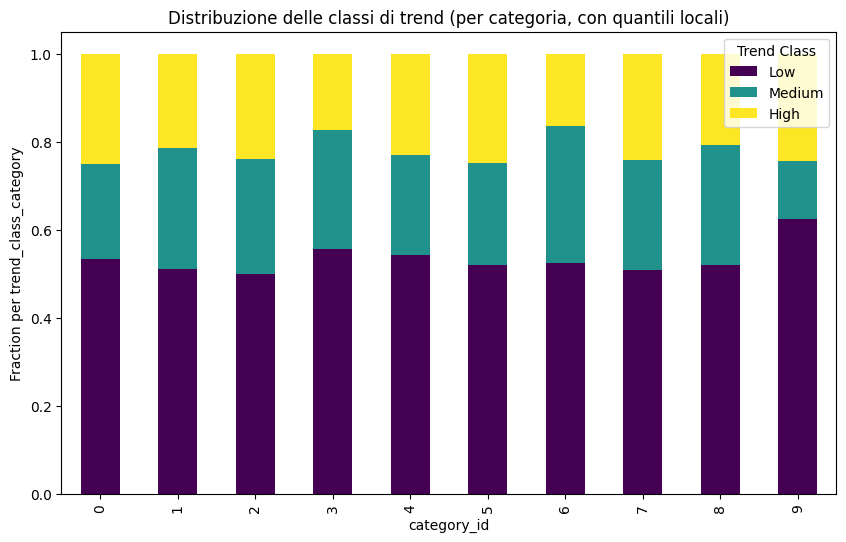

trend_class_category,0,1,2
category_id,,,
0,0.533365,0.216655,0.249980
1,0.510061,0.274636,0.215303
2,0.500358,0.259922,0.239720
3,0.557146,0.270023,0.172831
4,0.543307,0.226358,0.230335
5,0.520719,0.231289,0.247992
6,0.523503,0.312734,0.163764
7,0.508232,0.250219,0.241549
8,0.519208,0.273602,0.207190


In [83]:
import matplotlib.pyplot as plt

# Group by category_id and show distribution for trend_class_category
dist_cat = df.groupby('category_id')['trend_class_category'].value_counts(normalize=True).unstack(fill_value=0)

# Stacked bar plot for the first 10 categories
dist_cat.head(10).plot(kind='bar', stacked=True, colormap='viridis', figsize=(10,6))
plt.title('Distribuzione delle classi di trend (per categoria, con quantili locali)')
plt.xlabel('category_id')
plt.ylabel('Fraction per trend_class_category')
plt.legend(['Low', 'Medium', 'High'], title='Trend Class')
plt.show()

# (Optional) Show the entire table (increase pandas display options if needed)
import pandas as pd
pd.set_option('display.max_rows', 100)
display(dist_cat)
pd.reset_option('display.max_rows')

### Train/Test Split

Split the data into training and test sets, while preserving the distribution of the target classes using stratification.

In [84]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.20, random_state=42
)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
print("Train set size:", X_train.shape)
print("Test set size:", X_test.shape)

Train set size: (965606, 12)
Test set size: (241402, 12)


### LightGBM Modeling with GridSearchCV and Optuna Hyperparameter Tuning

In this step, we train a LightGBM classifier using cross-validation and hyperparameter tuning.

In [85]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report

#### Optuna Hyperparameter Tuning

In [86]:
import optuna
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold

X_train = X_train[:300000]
y_train = y_train[:300000]

def objective(trial):
    param = {
        'objective': 'multiclass',
        'num_class': 3,
        'metric': 'multi_logloss',
        # Range più stretti attorno al best value trovato
        'num_leaves': trial.suggest_int('num_leaves', 170, 210),        # attorno a 189
        'learning_rate': trial.suggest_float('learning_rate', 0.22, 0.29),   # attorno a 0.26
        'n_estimators': trial.suggest_int('n_estimators', 450, 520),    # attorno a 491
        'max_depth': trial.suggest_int('max_depth', 13, 17),            # attorno a 15
        'feature_fraction': trial.suggest_float('feature_fraction', 0.85, 0.92),  # attorno a 0.88
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.92, 0.98),  # attorno a 0.95
        'bagging_freq': trial.suggest_int('bagging_freq', 2, 4),         # attorno a 3
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),     # opzionale, per robustezza
        'class_weight': 'balanced',
        'random_state': 42
    }
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = []
    for train_idx, val_idx in cv.split(X_train, y_train):
        model = LGBMClassifier(**param)
        model.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
        score = model.score(X_train.iloc[val_idx], y_train.iloc[val_idx])
        scores.append(score)
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)
print("Best parameters found by Optuna:", study.best_params)

[I 2025-05-06 10:07:34,633] A new study created in memory with name: no-name-dfa13cd2-f293-4e09-9f66-cda63f93eed5


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8504807487571215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8504807487571215
[LightGBM] [Warning] bagging_fraction is set=0.9507010239474184, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9507010239474184
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8504807487571215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8504807487571215
[LightGBM] [Warning] bagging_fraction is set=0.9507010239474184, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9507010239474184
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001118 seconds

[I 2025-05-06 10:09:29,059] Trial 0 finished with value: 0.6234433333333333 and parameters: {'num_leaves': 171, 'learning_rate': 0.27520334268618035, 'n_estimators': 473, 'max_depth': 14, 'feature_fraction': 0.8504807487571215, 'bagging_fraction': 0.9507010239474184, 'bagging_freq': 4, 'min_child_samples': 48}. Best is trial 0 with value: 0.6234433333333333.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9045962488118905, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9045962488118905
[LightGBM] [Warning] bagging_fraction is set=0.9233378478666971, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9233378478666971
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9045962488118905, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9045962488118905
[LightGBM] [Warning] bagging_fraction is set=0.9233378478666971, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9233378478666971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001175 seconds

[I 2025-05-06 10:11:26,155] Trial 1 finished with value: 0.6285633333333333 and parameters: {'num_leaves': 183, 'learning_rate': 0.22192929074006237, 'n_estimators': 467, 'max_depth': 15, 'feature_fraction': 0.9045962488118905, 'bagging_fraction': 0.9233378478666971, 'bagging_freq': 2, 'min_child_samples': 33}. Best is trial 1 with value: 0.6285633333333333.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8875757368916395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8875757368916395
[LightGBM] [Warning] bagging_fraction is set=0.9593586568744893, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9593586568744893
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8875757368916395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8875757368916395
[LightGBM] [Warning] bagging_fraction is set=0.9593586568744893, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9593586568744893
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001146 seconds

[I 2025-05-06 10:13:37,119] Trial 2 finished with value: 0.6257833333333332 and parameters: {'num_leaves': 196, 'learning_rate': 0.2571564436012403, 'n_estimators': 517, 'max_depth': 17, 'feature_fraction': 0.8875757368916395, 'bagging_fraction': 0.9593586568744893, 'bagging_freq': 4, 'min_child_samples': 65}. Best is trial 1 with value: 0.6285633333333333.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8838255245301813, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8838255245301813
[LightGBM] [Warning] bagging_fraction is set=0.9569456851218924, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9569456851218924
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8838255245301813, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8838255245301813
[LightGBM] [Warning] bagging_fraction is set=0.9569456851218924, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9569456851218924
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001131 seconds

[I 2025-05-06 10:15:28,404] Trial 3 finished with value: 0.63054 and parameters: {'num_leaves': 174, 'learning_rate': 0.22721174530424523, 'n_estimators': 490, 'max_depth': 14, 'feature_fraction': 0.8838255245301813, 'bagging_fraction': 0.9569456851218924, 'bagging_freq': 2, 'min_child_samples': 31}. Best is trial 3 with value: 0.63054.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8566667250546238, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8566667250546238
[LightGBM] [Warning] bagging_fraction is set=0.9256079982151615, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9256079982151615
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8566667250546238, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8566667250546238
[LightGBM] [Warning] bagging_fraction is set=0.9256079982151615, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9256079982151615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001144 seconds

[I 2025-05-06 10:17:42,391] Trial 4 finished with value: 0.6282033333333334 and parameters: {'num_leaves': 207, 'learning_rate': 0.23908203465330247, 'n_estimators': 499, 'max_depth': 13, 'feature_fraction': 0.8566667250546238, 'bagging_fraction': 0.9256079982151615, 'bagging_freq': 3, 'min_child_samples': 32}. Best is trial 3 with value: 0.63054.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8953946849614731, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8953946849614731
[LightGBM] [Warning] bagging_fraction is set=0.9306343730379185, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9306343730379185
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8953946849614731, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8953946849614731
[LightGBM] [Warning] bagging_fraction is set=0.9306343730379185, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9306343730379185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001125 seconds

[I 2025-05-06 10:19:47,104] Trial 5 finished with value: 0.6198199999999999 and parameters: {'num_leaves': 203, 'learning_rate': 0.22076128886031937, 'n_estimators': 451, 'max_depth': 14, 'feature_fraction': 0.8953946849614731, 'bagging_fraction': 0.9306343730379185, 'bagging_freq': 4, 'min_child_samples': 67}. Best is trial 3 with value: 0.63054.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9134158967905728, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9134158967905728
[LightGBM] [Warning] bagging_fraction is set=0.9795338445895466, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9795338445895466
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9134158967905728, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9134158967905728
[LightGBM] [Warning] bagging_fraction is set=0.9795338445895466, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9795338445895466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001117 seconds

[I 2025-05-06 10:21:44,431] Trial 6 finished with value: 0.62093 and parameters: {'num_leaves': 175, 'learning_rate': 0.24085584147461972, 'n_estimators': 476, 'max_depth': 14, 'feature_fraction': 0.9134158967905728, 'bagging_fraction': 0.9795338445895466, 'bagging_freq': 3, 'min_child_samples': 75}. Best is trial 3 with value: 0.63054.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8959861227075734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8959861227075734
[LightGBM] [Warning] bagging_fraction is set=0.9267337744597628, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9267337744597628
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8959861227075734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8959861227075734
[LightGBM] [Warning] bagging_fraction is set=0.9267337744597628, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9267337744597628
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001184 seconds

[I 2025-05-06 10:23:47,817] Trial 7 finished with value: 0.6290366666666667 and parameters: {'num_leaves': 196, 'learning_rate': 0.2231227824709338, 'n_estimators': 475, 'max_depth': 17, 'feature_fraction': 0.8959861227075734, 'bagging_fraction': 0.9267337744597628, 'bagging_freq': 2, 'min_child_samples': 36}. Best is trial 3 with value: 0.63054.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8768534509181365, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8768534509181365
[LightGBM] [Warning] bagging_fraction is set=0.9542073061815891, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9542073061815891
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8768534509181365, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8768534509181365
[LightGBM] [Warning] bagging_fraction is set=0.9542073061815891, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9542073061815891
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001126 seconds

[I 2025-05-06 10:25:38,104] Trial 8 finished with value: 0.6352566666666667 and parameters: {'num_leaves': 190, 'learning_rate': 0.2224801562758738, 'n_estimators': 461, 'max_depth': 14, 'feature_fraction': 0.8768534509181365, 'bagging_fraction': 0.9542073061815891, 'bagging_freq': 4, 'min_child_samples': 22}. Best is trial 8 with value: 0.6352566666666667.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8585713056119598, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8585713056119598
[LightGBM] [Warning] bagging_fraction is set=0.9420445160537261, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9420445160537261
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8585713056119598, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8585713056119598
[LightGBM] [Warning] bagging_fraction is set=0.9420445160537261, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9420445160537261
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001106 seconds

[I 2025-05-06 10:27:45,885] Trial 9 finished with value: 0.61823 and parameters: {'num_leaves': 172, 'learning_rate': 0.28214946586792883, 'n_estimators': 499, 'max_depth': 14, 'feature_fraction': 0.8585713056119598, 'bagging_fraction': 0.9420445160537261, 'bagging_freq': 2, 'min_child_samples': 72}. Best is trial 8 with value: 0.6352566666666667.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8713127778926105, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8713127778926105
[LightGBM] [Warning] bagging_fraction is set=0.9719475131384194, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9719475131384194
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8713127778926105, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8713127778926105
[LightGBM] [Warning] bagging_fraction is set=0.9719475131384194, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9719475131384194
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001170 seconds

[I 2025-05-06 10:29:46,302] Trial 10 finished with value: 0.6171633333333334 and parameters: {'num_leaves': 187, 'learning_rate': 0.2572065518176817, 'n_estimators': 450, 'max_depth': 16, 'feature_fraction': 0.8713127778926105, 'bagging_fraction': 0.9719475131384194, 'bagging_freq': 4, 'min_child_samples': 87}. Best is trial 8 with value: 0.6352566666666667.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8736435853210897, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8736435853210897
[LightGBM] [Warning] bagging_fraction is set=0.9604605648814097, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9604605648814097
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8736435853210897, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8736435853210897
[LightGBM] [Warning] bagging_fraction is set=0.9604605648814097, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9604605648814097
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001091 seconds

[I 2025-05-06 10:31:43,367] Trial 11 finished with value: 0.6327166666666666 and parameters: {'num_leaves': 181, 'learning_rate': 0.23821315922016117, 'n_estimators': 493, 'max_depth': 13, 'feature_fraction': 0.8736435853210897, 'bagging_fraction': 0.9604605648814097, 'bagging_freq': 3, 'min_child_samples': 21}. Best is trial 8 with value: 0.6352566666666667.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8701807163427753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8701807163427753
[LightGBM] [Warning] bagging_fraction is set=0.9615420896344355, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9615420896344355
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8701807163427753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8701807163427753
[LightGBM] [Warning] bagging_fraction is set=0.9615420896344355, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9615420896344355
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001113 seconds

[I 2025-05-06 10:33:41,558] Trial 12 finished with value: 0.6346066666666667 and parameters: {'num_leaves': 181, 'learning_rate': 0.24161714836548376, 'n_estimators': 512, 'max_depth': 13, 'feature_fraction': 0.8701807163427753, 'bagging_fraction': 0.9615420896344355, 'bagging_freq': 3, 'min_child_samples': 21}. Best is trial 8 with value: 0.6352566666666667.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8741493441533292, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8741493441533292
[LightGBM] [Warning] bagging_fraction is set=0.9415148468180249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9415148468180249
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8741493441533292, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8741493441533292
[LightGBM] [Warning] bagging_fraction is set=0.9415148468180249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9415148468180249
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001136 seconds

[I 2025-05-06 10:35:56,454] Trial 13 finished with value: 0.6239466666666666 and parameters: {'num_leaves': 192, 'learning_rate': 0.2452725428664652, 'n_estimators': 518, 'max_depth': 13, 'feature_fraction': 0.8741493441533292, 'bagging_fraction': 0.9415148468180249, 'bagging_freq': 3, 'min_child_samples': 47}. Best is trial 8 with value: 0.6352566666666667.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8658513741583067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8658513741583067
[LightGBM] [Warning] bagging_fraction is set=0.9677995318369158, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9677995318369158
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8658513741583067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8658513741583067
[LightGBM] [Warning] bagging_fraction is set=0.9677995318369158, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9677995318369158
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001122 seconds

[I 2025-05-06 10:37:51,185] Trial 14 finished with value: 0.63422 and parameters: {'num_leaves': 180, 'learning_rate': 0.268903320661625, 'n_estimators': 459, 'max_depth': 13, 'feature_fraction': 0.8658513741583067, 'bagging_fraction': 0.9677995318369158, 'bagging_freq': 3, 'min_child_samples': 20}. Best is trial 8 with value: 0.6352566666666667.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8835191534734327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8835191534734327
[LightGBM] [Warning] bagging_fraction is set=0.9458496096471842, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9458496096471842
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8835191534734327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8835191534734327
[LightGBM] [Warning] bagging_fraction is set=0.9458496096471842, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9458496096471842
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001153 seconds

[I 2025-05-06 10:39:59,474] Trial 15 finished with value: 0.6252833333333333 and parameters: {'num_leaves': 188, 'learning_rate': 0.23205835318482104, 'n_estimators': 506, 'max_depth': 15, 'feature_fraction': 0.8835191534734327, 'bagging_fraction': 0.9458496096471842, 'bagging_freq': 4, 'min_child_samples': 49}. Best is trial 8 with value: 0.6352566666666667.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8656172764180496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8656172764180496
[LightGBM] [Warning] bagging_fraction is set=0.9672478836168793, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9672478836168793
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8656172764180496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8656172764180496
[LightGBM] [Warning] bagging_fraction is set=0.9672478836168793, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9672478836168793
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001155 seconds

[I 2025-05-06 10:42:11,657] Trial 16 finished with value: 0.6176866666666667 and parameters: {'num_leaves': 194, 'learning_rate': 0.24959148071197315, 'n_estimators': 483, 'max_depth': 15, 'feature_fraction': 0.8656172764180496, 'bagging_fraction': 0.9672478836168793, 'bagging_freq': 3, 'min_child_samples': 95}. Best is trial 8 with value: 0.6352566666666667.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.879581601597795, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.879581601597795
[LightGBM] [Warning] bagging_fraction is set=0.9524699471568381, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9524699471568381
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.879581601597795, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.879581601597795
[LightGBM] [Warning] bagging_fraction is set=0.9524699471568381, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9524699471568381
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001136 seconds.
Yo

[I 2025-05-06 10:44:10,817] Trial 17 finished with value: 0.6285766666666667 and parameters: {'num_leaves': 202, 'learning_rate': 0.23398882714616812, 'n_estimators': 462, 'max_depth': 16, 'feature_fraction': 0.879581601597795, 'bagging_fraction': 0.9524699471568381, 'bagging_freq': 4, 'min_child_samples': 41}. Best is trial 8 with value: 0.6352566666666667.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.894160778793932, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.894160778793932
[LightGBM] [Warning] bagging_fraction is set=0.9328298007452813, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9328298007452813
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.894160778793932, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.894160778793932
[LightGBM] [Warning] bagging_fraction is set=0.9328298007452813, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9328298007452813
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001148 seconds.
Yo

[I 2025-05-06 10:46:13,997] Trial 18 finished with value: 0.6222666666666666 and parameters: {'num_leaves': 179, 'learning_rate': 0.26361137040010685, 'n_estimators': 506, 'max_depth': 13, 'feature_fraction': 0.894160778793932, 'bagging_fraction': 0.9328298007452813, 'bagging_freq': 3, 'min_child_samples': 56}. Best is trial 8 with value: 0.6352566666666667.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8651406156647429, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8651406156647429
[LightGBM] [Warning] bagging_fraction is set=0.9642789701773024, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9642789701773024
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8651406156647429, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8651406156647429
[LightGBM] [Warning] bagging_fraction is set=0.9642789701773024, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9642789701773024
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001167 seconds

[I 2025-05-06 10:48:08,516] Trial 19 finished with value: 0.6321766666666666 and parameters: {'num_leaves': 185, 'learning_rate': 0.2496915011631563, 'n_estimators': 486, 'max_depth': 14, 'feature_fraction': 0.8651406156647429, 'bagging_fraction': 0.9642789701773024, 'bagging_freq': 3, 'min_child_samples': 25}. Best is trial 8 with value: 0.6352566666666667.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8791004440690343, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8791004440690343
[LightGBM] [Warning] bagging_fraction is set=0.9757032331426183, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9757032331426183
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8791004440690343, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8791004440690343
[LightGBM] [Warning] bagging_fraction is set=0.9757032331426183, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9757032331426183
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001347 seconds

[I 2025-05-06 10:50:09,069] Trial 20 finished with value: 0.6371933333333334 and parameters: {'num_leaves': 190, 'learning_rate': 0.2890152737477537, 'n_estimators': 511, 'max_depth': 15, 'feature_fraction': 0.8791004440690343, 'bagging_fraction': 0.9757032331426183, 'bagging_freq': 4, 'min_child_samples': 27}. Best is trial 20 with value: 0.6371933333333334.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8776605037380006, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8776605037380006
[LightGBM] [Warning] bagging_fraction is set=0.9778974124211404, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9778974124211404
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8776605037380006, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8776605037380006
[LightGBM] [Warning] bagging_fraction is set=0.9778974124211404, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9778974124211404
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001092 seconds

[I 2025-05-06 10:52:10,768] Trial 21 finished with value: 0.6383166666666668 and parameters: {'num_leaves': 190, 'learning_rate': 0.2896887272881949, 'n_estimators': 510, 'max_depth': 15, 'feature_fraction': 0.8776605037380006, 'bagging_fraction': 0.9778974124211404, 'bagging_freq': 4, 'min_child_samples': 27}. Best is trial 21 with value: 0.6383166666666668.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8802521339622115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8802521339622115
[LightGBM] [Warning] bagging_fraction is set=0.9799949149652878, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9799949149652878
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8802521339622115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8802521339622115
[LightGBM] [Warning] bagging_fraction is set=0.9799949149652878, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9799949149652878
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001137 seconds

[I 2025-05-06 10:54:14,154] Trial 22 finished with value: 0.6379400000000001 and parameters: {'num_leaves': 190, 'learning_rate': 0.2878863018587207, 'n_estimators': 508, 'max_depth': 15, 'feature_fraction': 0.8802521339622115, 'bagging_fraction': 0.9799949149652878, 'bagging_freq': 4, 'min_child_samples': 28}. Best is trial 21 with value: 0.6383166666666668.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8894893030552147, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8894893030552147
[LightGBM] [Warning] bagging_fraction is set=0.9797070603005562, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9797070603005562
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8894893030552147, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8894893030552147
[LightGBM] [Warning] bagging_fraction is set=0.9797070603005562, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9797070603005562
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001249 seconds

[I 2025-05-06 10:56:23,967] Trial 23 finished with value: 0.63475 and parameters: {'num_leaves': 197, 'learning_rate': 0.28989869571556764, 'n_estimators': 510, 'max_depth': 16, 'feature_fraction': 0.8894893030552147, 'bagging_fraction': 0.9797070603005562, 'bagging_freq': 4, 'min_child_samples': 40}. Best is trial 21 with value: 0.6383166666666668.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8809124435056035, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8809124435056035
[LightGBM] [Warning] bagging_fraction is set=0.9750379780330455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9750379780330455
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8809124435056035, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8809124435056035
[LightGBM] [Warning] bagging_fraction is set=0.9750379780330455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9750379780330455
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001153 seconds

[I 2025-05-06 10:58:27,519] Trial 24 finished with value: 0.63877 and parameters: {'num_leaves': 200, 'learning_rate': 0.28895282410037054, 'n_estimators': 502, 'max_depth': 15, 'feature_fraction': 0.8809124435056035, 'bagging_fraction': 0.9750379780330455, 'bagging_freq': 4, 'min_child_samples': 27}. Best is trial 24 with value: 0.63877.


Best parameters found by Optuna: {'num_leaves': 200, 'learning_rate': 0.28895282410037054, 'n_estimators': 502, 'max_depth': 15, 'feature_fraction': 0.8809124435056035, 'bagging_fraction': 0.9750379780330455, 'bagging_freq': 4, 'min_child_samples': 27}


### Final model training with best hyperparameters from Optuna

In [87]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.20, random_state=42
)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
print("Train set size:", X_train.shape)
print("Test set size:", X_test.shape)

Train set size: (965606, 12)
Test set size: (241402, 12)


In [88]:
best_params = study.best_params
best_params.update({'objective': 'multiclass', 'num_class': 3, 'class_weight': 'balanced', 'random_state': 42})
model = LGBMClassifier(**best_params)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(
    y_test, y_pred, target_names=['Low Trend', 'Medium Trend', 'High Trend']
))

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8809124435056035, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8809124435056035
[LightGBM] [Warning] bagging_fraction is set=0.9750379780330455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9750379780330455
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8809124435056035, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8809124435056035
[LightGBM] [Warning] bagging_fraction is set=0.9750379780330455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9750379780330455
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005677 seconds

            feature  importance_pct
11      category_id       22.300747
10  slm pressure mb       13.804748
3       max temp °C        8.825335
6     visibility km        8.203034
5        humidity %        7.821311
4      dew point °C        7.248727
1       avg temp °C        7.106916
7     avg wind km/h        6.723191
8     max wind km/h        6.718520
2       min temp °C        6.708176
0          locality        2.890615
9         gust km/h        1.648682


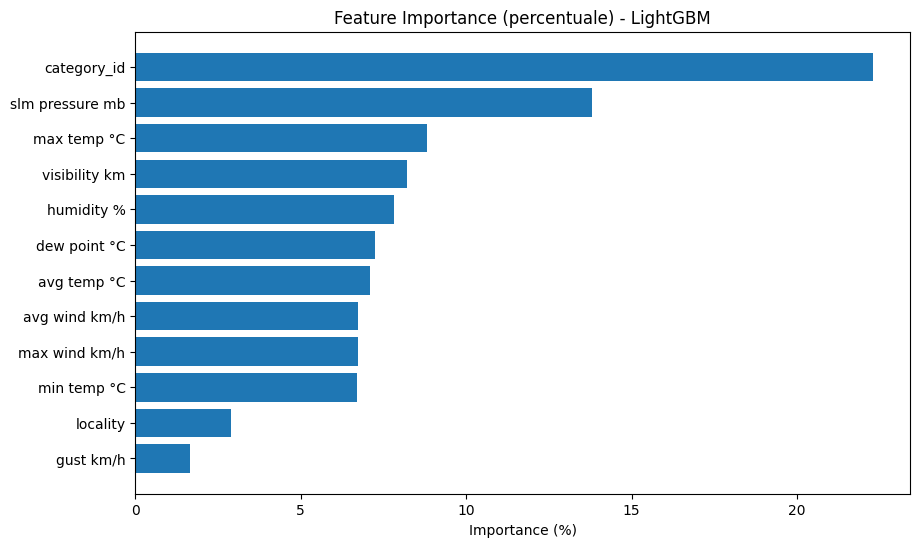

In [89]:
import pandas as pd
import matplotlib.pyplot as plt

# Calcola la feature importance
importances = model.feature_importances_
feature_imp = pd.DataFrame({
    "feature": X.columns,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Calcola la percentuale di importanza di ciascuna feature
feature_imp["importance_pct"] = 100 * feature_imp["importance"] / feature_imp["importance"].sum()

# Visualizza con valori percentuali arrotondati
print(feature_imp[["feature", "importance_pct"]])

# (Facoltativo) Grafico a barre percentuale
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.barh(feature_imp["feature"], feature_imp["importance_pct"])
plt.xlabel("Importance (%)")
plt.title("Feature Importance (percentuale) - LightGBM")
plt.gca().invert_yaxis()
plt.show()

### Save the Model and Processed Dataset

Export the fused dataset and, if needed, the trained model for future use.

In [90]:
import joblib

# Save the merged dataset with features and label
df.to_parquet('./data/output/trend_weather_forecast/trend_weather_fusion_labeled.parquet', index=False)

# Save the trained model
joblib.dump(model, './data/output/trend_weather_forecast/lgbm.joblib')

['./data/output/trend_weather_forecast/lgbm.joblib']

## Summary

You have created a weekly-level multimodal dataset joining Google Trends and weather data, engineered features, 
labeled the target with three trend classes, and trained/evaluated a baseline random forest classifier.

This dataset and model can now be used as the first layer in your ensemble architecture.